In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path
import random
from collections import Counter

# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns
from cycler import cycler
import textwrap

sns.set_style('darkgrid')

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [ ]:
# %load https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
### We create a bunch of helpful functions throughout the course.
### Storing them here so they're easily accessible.

import tensorflow as tf

# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

# Note: The following confusion matrix code is a remix of Scikit-Learn's
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

# Make a function to predict on images and plot them (works with multi-class)
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Plot the validation and training data separately
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.

    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here)
    """

    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

# Create function to unzip a zipfile into current working directory
# (since we're going to be downloading and unzipping a few files)
import zipfile

def unzip_data(filename):
  """
  Unzips filename into the current working directory.

  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.

  Args:
    dir_path (str): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results


In [ ]:
# Seed Everything to reproduce results for future use cases
def seed_everything(seed=42):
    # Seed value for TensorFlow
    tf.random.set_seed(seed)

    # Seed value for NumPy
    np.random.seed(seed)

    # Seed value for Python's random library
    random.seed(seed)

    # Force TensorFlow to use single thread
    # Multiple threads are a potential source of non-reproducible results.
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )

    # Make sure that TensorFlow uses a deterministic operation wherever possible
    tf.compat.v1.set_random_seed(seed)

    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

seed_everything()

In [ ]:
def create_image_dataframe(dataset_path: str) -> pd.DataFrame:
    image_dir = Path(dataset_path)

    # Get filepaths for various extensions
    filepaths = list(image_dir.glob(r'**/*.JPG')) + \
                list(image_dir.glob(r'**/*.jpg')) + \
                list(image_dir.glob(r'**/*.png')) + \
                list(image_dir.glob(r'**/*.PNG'))

    # Extract labels from filepaths
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    # Convert lists to Series
    filepaths_series = pd.Series(filepaths, name='Filepath').astype(str)
    labels_series = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels into a DataFrame
    image_df = pd.concat([filepaths_series, labels_series], axis=1)

    return image_df

# Usage
test_dataset = "/content/drive/MyDrive/Colab Notebooks/Mango/src/data/MangoLeafBD_Without_Testset_Augmentation/Test"
train_dataset = "/content/drive/MyDrive/Colab Notebooks/Mango/src/data/MangoLeafBD_Without_Testset_Augmentation/Train"

test_df = create_image_dataframe(test_dataset)
train_df = create_image_dataframe(train_dataset)

In [ ]:
test_df

,Filepath,Label
0,/content/drive/MyDrive/Colab Notebooks/Mango/s...,Anthracnose
1,/content/drive/MyDrive/Colab Notebooks/Mango/s...,Anthracnose
2,/content/drive/MyDrive/Colab Notebooks/Mango/s...,Anthracnose
3,/content/drive/MyDrive/Colab Notebooks/Mango/s...,Anthracnose
4,/content/drive/MyDrive/Colab Notebooks/Mango/s...,Anthracnose
...,...,...
225,/content/drive/MyDrive/Colab Notebooks/Mango/s...,Powdery Mildew
226,/content/drive/MyDrive/Colab Notebooks/Mango/s...,Powdery Mildew
227,/content/drive/MyDrive/Colab Notebooks/Mango/s...,Powdery Mildew
228,/content/drive/MyDrive/Colab Notebooks/Mango/s...,Powdery Mildew


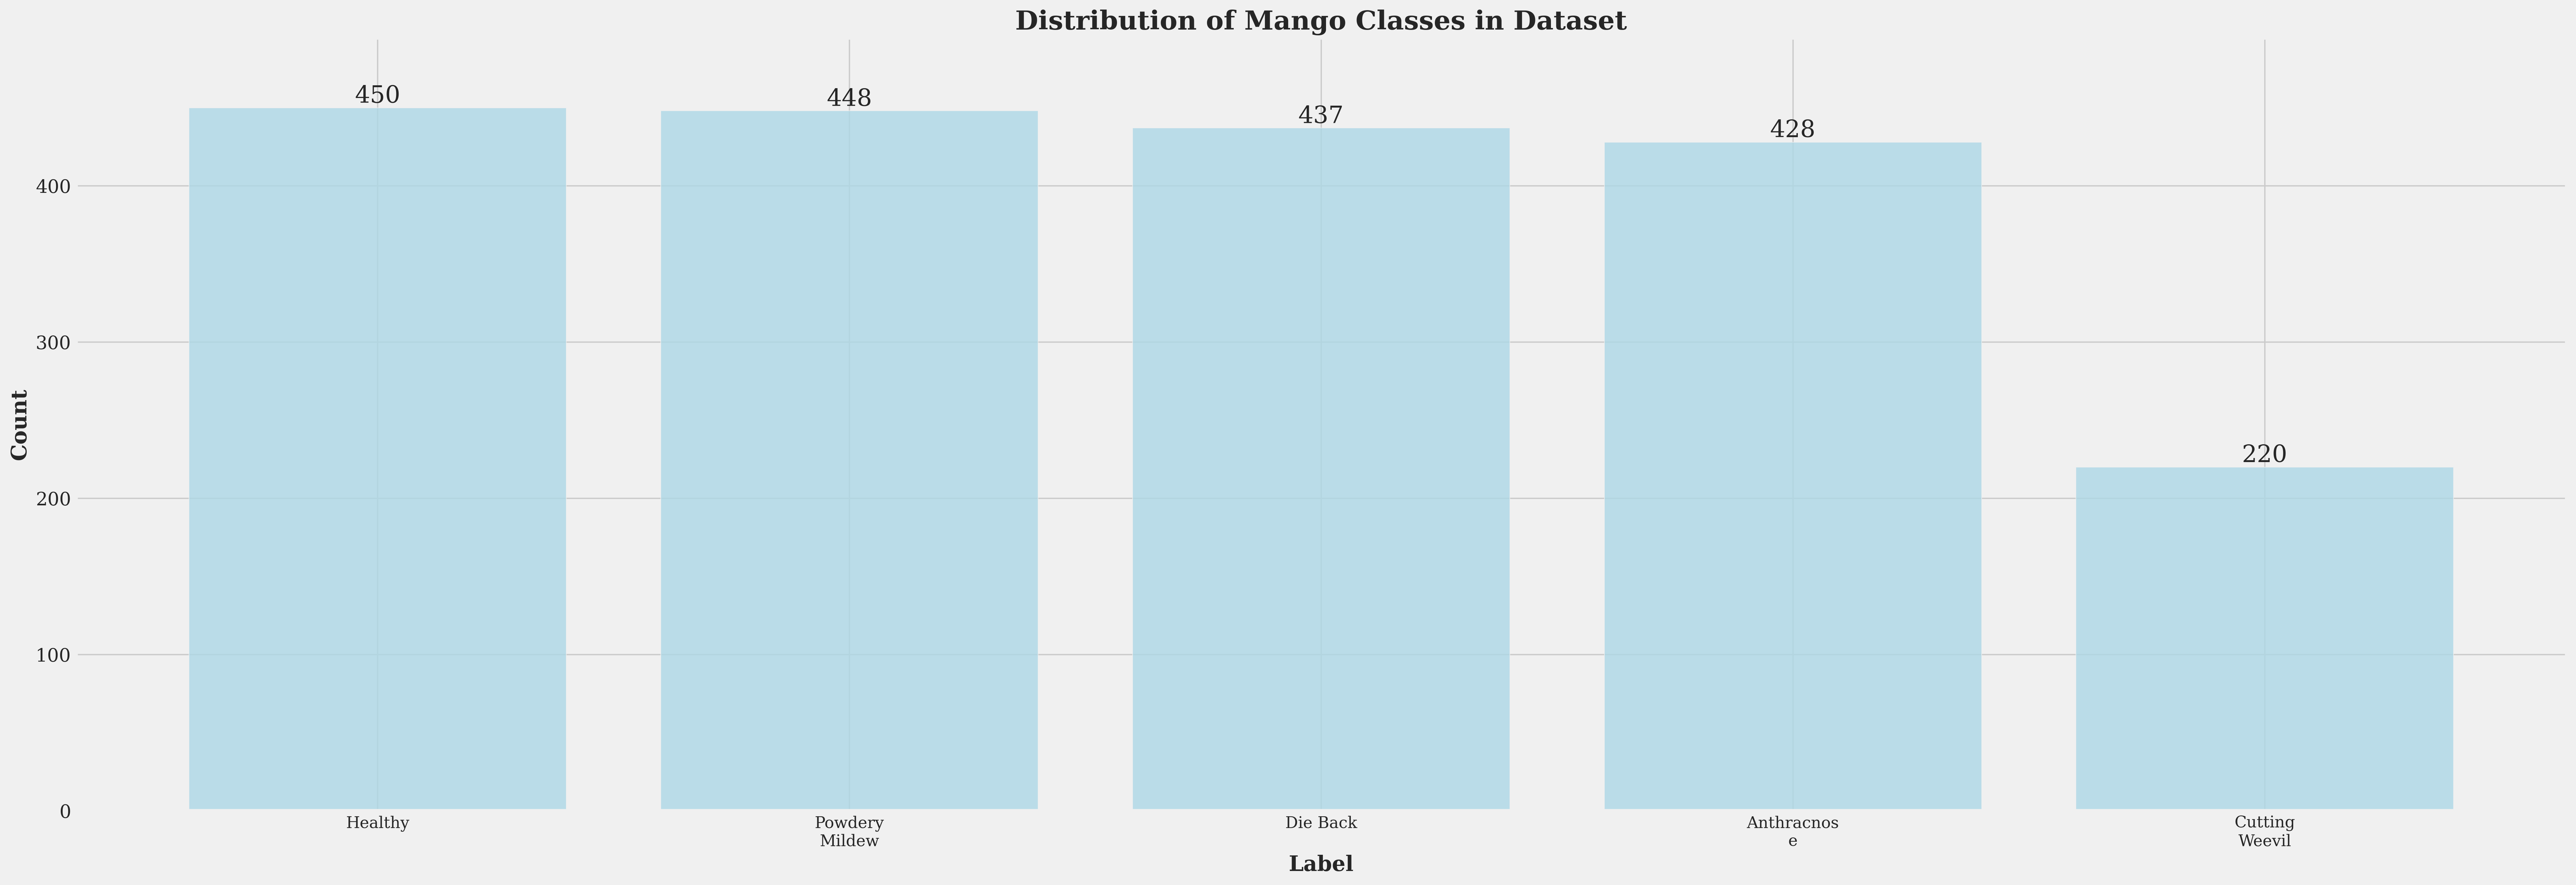

In [ ]:
plt.style.use('fivethirtyeight')

# Get the labels
label_counts = train_df['Label'].value_counts()[:]

# Create a cycler object using the desired colors
color_cycler = (cycler(color=["#ADD8E6"]))  # light blue color

# Set the property cycle of the axes to the created cycler object
plt.rc('axes', prop_cycle=color_cycler)

# Other styling options
plt.rc("font", family="serif", size=18.)
plt.rc("savefig", dpi=200)
plt.rc("legend", loc="best", fontsize="medium", fancybox=True, framealpha=0.5)
plt.rc("lines", linewidth=2.5, markersize=10, markeredgewidth=2.5)

plt.figure(figsize=(30, 10), dpi=300)  # Increase figure size
bars = plt.bar(label_counts.index, label_counts.values, alpha=0.8)
plt.title('Distribution of Mango Classes in Dataset', fontsize=20, fontweight='bold')
plt.xlabel('Label', fontsize=16, fontweight='bold')
plt.ylabel('Count', fontsize=16, fontweight='bold')

# Wrap x-labels
wrapped_labels = ['\n'.join(textwrap.wrap(label, 10)) for label in label_counts.index]
plt.xticks(range(len(wrapped_labels)), wrapped_labels, fontsize=12, ha='center')  # Change alignment to 'center'

plt.yticks(fontsize=14)

# Adjust y limit to avoid overlapping
plt.ylim(0, max(label_counts) * 1.1)  # Set y limit 10% higher than the max value

# Add value annotations on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, int(yval), ha='center', va='bottom')

plt.show()


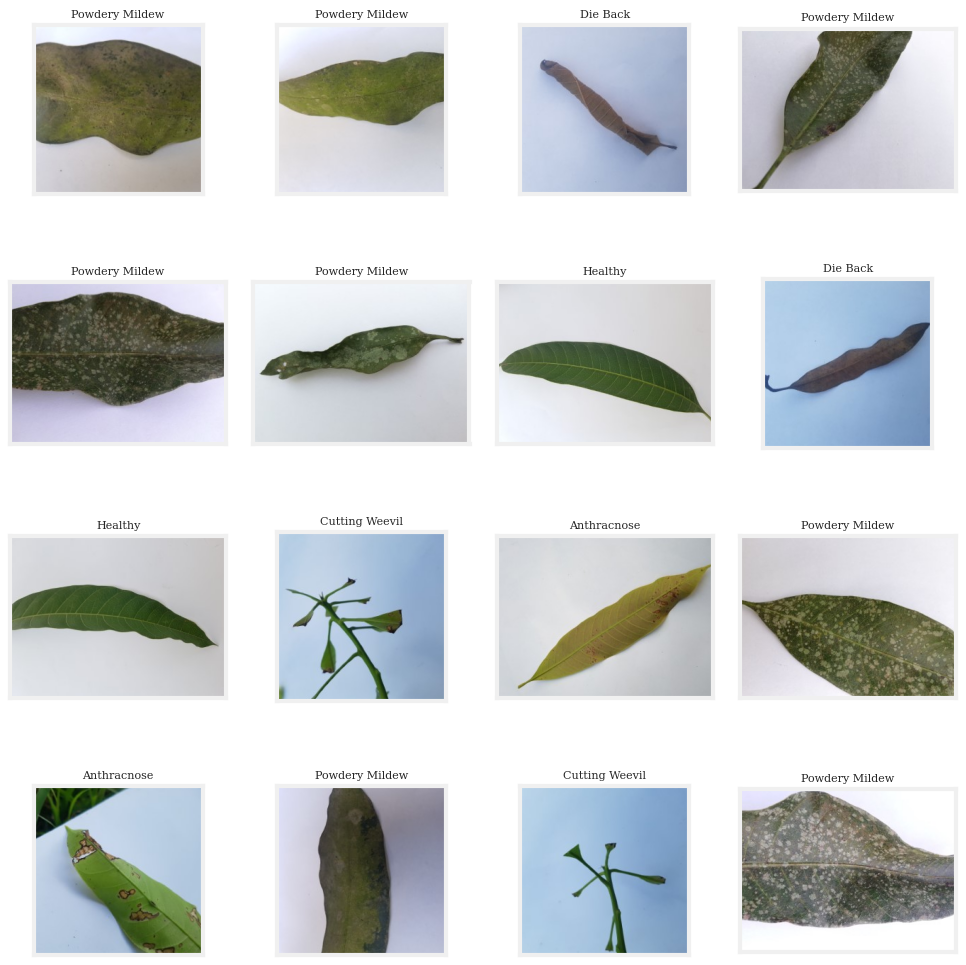

In [ ]:
# Set title size and figure background color
plt.rcParams['axes.titlesize'] = 'small'  # Adjust as needed
plt.rcParams['figure.facecolor'] = 'white'  # Set figure background color to white

# Display 16 pictures of the dataset with their labels
random_index = np.random.randint(0, len(train_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(train_df.Filepath[random_index[i]]))
    title = train_df.Label[random_index[i]]
    ax.set_title("\n".join(textwrap.wrap(title, 20)), fontsize=8)  # Wrap long titles
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)  # Increase vertical space between subplots
plt.show()


In [ ]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')

    items = list(items)

    p = random.choice(items)
    return p.as_posix()

In [ ]:
# View random sample from the dataset
p = random_sample('/content/drive/MyDrive/Colab Notebooks/Mango/src/data/MangoLeafBD_Without_Testset_Augmentation/Train/Anthracnose')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
fig.suptitle('Error Level Analysis', fontsize=20)  # Add super title
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
    ax.set_xticks([])  # Remove x-ticks
    ax.set_yticks([])  # Remove y-ticks
plt.show()


In [ ]:
# Separate in train and test data
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
)

In [ ]:
from sklearn.model_selection import train_test_split

# Shuffle your dataframe for randomness
train_df = train_df.sample(frac=1).reset_index(drop=True)

# Stratified Split
train_df, val_df = train_test_split(train_df, test_size=0.3, stratify=train_df['Label'])

# Now use train_df with train_images generator and val_df with val_images generator without the subset parameter
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1388 validated image filenames belonging to 5 classes.
Found 595 validated image filenames belonging to 5 classes.
Found 230 validated image filenames belonging to 5 classes.


In [ ]:
# Function to get distribution from the generator
def get_distribution(generator):
    # Counting occurrences for each class
    counter = Counter(generator.classes)
    max_val = float(max(counter.values()))
    return {k: v/max_val for k, v in counter.items()}

# Print distributions
print(get_distribution(train_images))
print(get_distribution(val_images))


{4: 0.9936507936507937, 0: 0.9523809523809523, 1: 0.4888888888888889, 3: 1.0, 2: 0.9714285714285714}
{3: 1.0, 1: 0.4888888888888889, 0: 0.9481481481481482, 4: 1.0, 2: 0.9703703703703703}


In [ ]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.resnet50.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

In [ ]:
# Create checkpoint callback
checkpoint_path = "mld_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [ ]:
from keras import backend as K

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


In [ ]:
# Existing model structure
inputs = pretrained_model.input
x = augment(inputs)
x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)
outputs = Dense(5, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

# Compile with custom F1-Score
model.compile(
    optimizer=Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', f1_score]
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        create_tensorboard_callback("training_logs", "mld_classification"),
        checkpoint_callback,
        reduce_lr
    ]
)

Saving TensorBoard log files to: training_logs/mld_classification/20240524-104939
Epoch 1/100
44/44 [==============================] - 17s 301ms/step - loss: 1.7060 - accuracy: 0.7003 - f1_score: 0.7069 - val_loss: 0.0360 - val_accuracy: 0.9933 - val_f1_score: 0.9918 - lr: 0.0010
Epoch 2/100
44/44 [==============================] - 12s 258ms/step - loss: 0.2423 - accuracy: 0.9179 - f1_score: 0.9151 - val_loss: 0.0257 - val_accuracy: 0.9916 - val_f1_score: 0.9909 - lr: 0.0010
Epoch 3/100
44/44 [==============================] - 12s 267ms/step - loss: 0.1263 - accuracy: 0.9633 - f1_score: 0.9603 - val_loss: 0.0273 - val_accuracy: 0.9899 - val_f1_score: 0.9917 - lr: 0.0010
Epoch 4/100
44/44 [==============================] - 12s 262ms/step - loss: 0.1017 - accuracy: 0.9669 - f1_score: 0.9674 - val_loss: 0.0300 - val_accuracy: 0.9899 - val_f1_score: 0.9885 - lr: 0.0010
Epoch 5/100
44/44 [==============================] - 12s 275ms/step - loss: 0.0827 - accuracy: 0.9697 - f1_score: 0.9721 -

In [ ]:
model.save_weights('mango_leaf_disease_ResNet50.h5')

In [ ]:
results = model.evaluate(test_images, verbose=0)
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))
print("  Test F1-score: {:.2f}%".format(results[2] * 100))

    Test Loss: 0.00029
Test Accuracy: 100.00%
  Test F1-score: 100.00%


In [ ]:
import os

file_size = os.path.getsize('mango_leaf_disease_ResNet50.h5') / (1024 * 1024)  # Convert bytes to MB
print(f"Model file size: {file_size:.2f} MB")

Model file size: 91.53 MB


In [ ]:
total_params = model.count_params()
print(f"Total parameters: {total_params}")
model.summary()

Total parameters: 23884293
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                             

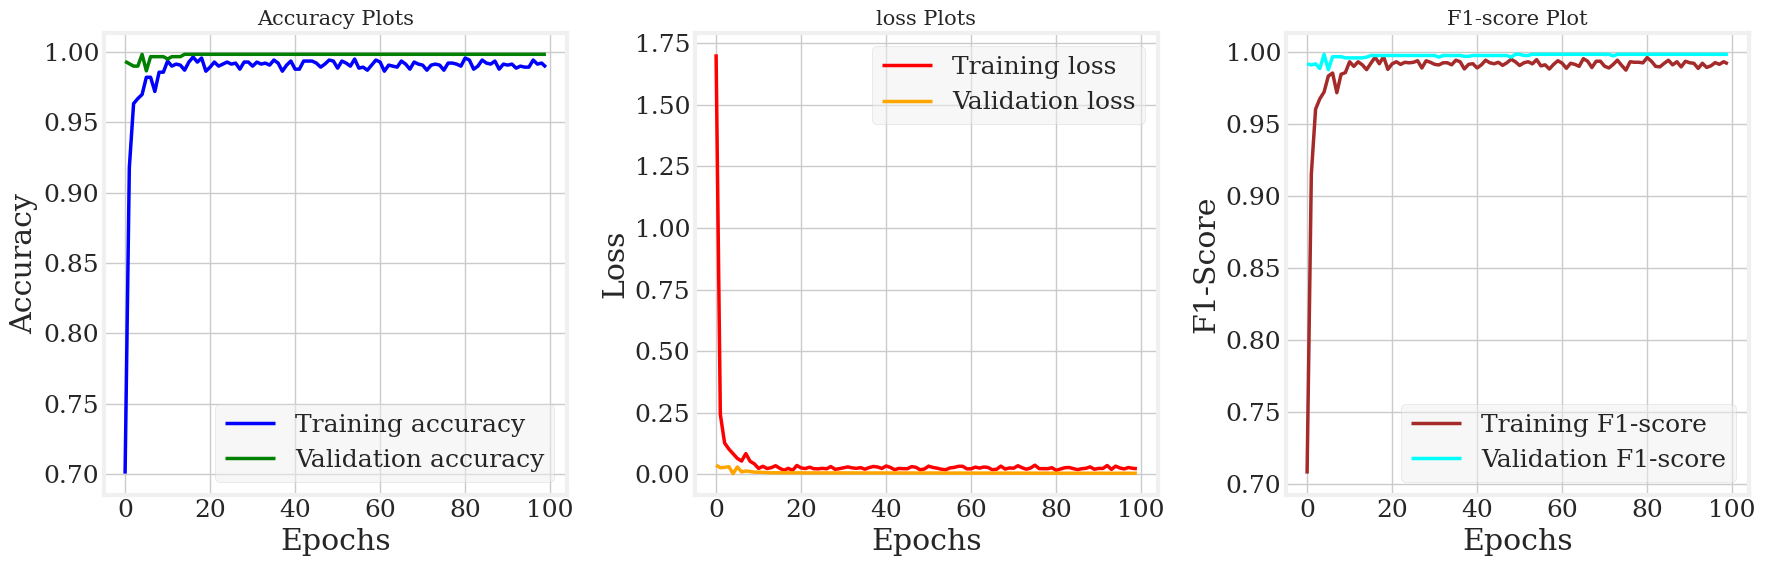

In [ ]:
# Extracting F1-score from the history object
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
f1 = history.history['f1_score']
val_f1 = history.history['val_f1_score']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))  # Create a 1x3 grid of plots

# Plot accuracy
ax1.plot(epochs, accuracy, 'b', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'g', label='Validation accuracy')
ax1.set_title('Accuracy Plots')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_facecolor("white")
ax1.legend()

# Plot loss
ax2.plot(epochs, loss, 'r', label='Training loss')
ax2.plot(epochs, val_loss, 'orange', label='Validation loss')
ax2.set_title('loss Plots')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_facecolor("white")
ax2.legend()

# Plot F1-score
ax3.plot(epochs, f1, 'brown', label='Training F1-score')
ax3.plot(epochs, val_f1, 'cyan', label='Validation F1-score')
ax3.set_title('F1-score Plot')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('F1-Score')
ax3.set_facecolor("white")
ax3.legend()

plt.tight_layout()  # Adjust the padding between and around the subplots
plt.show()


In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the labelz
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

8/8 [==============================] - 2s 218ms/step
The first 5 predictions: ['Anthracnose', 'Anthracnose', 'Anthracnose', 'Anthracnose', 'Anthracnose']


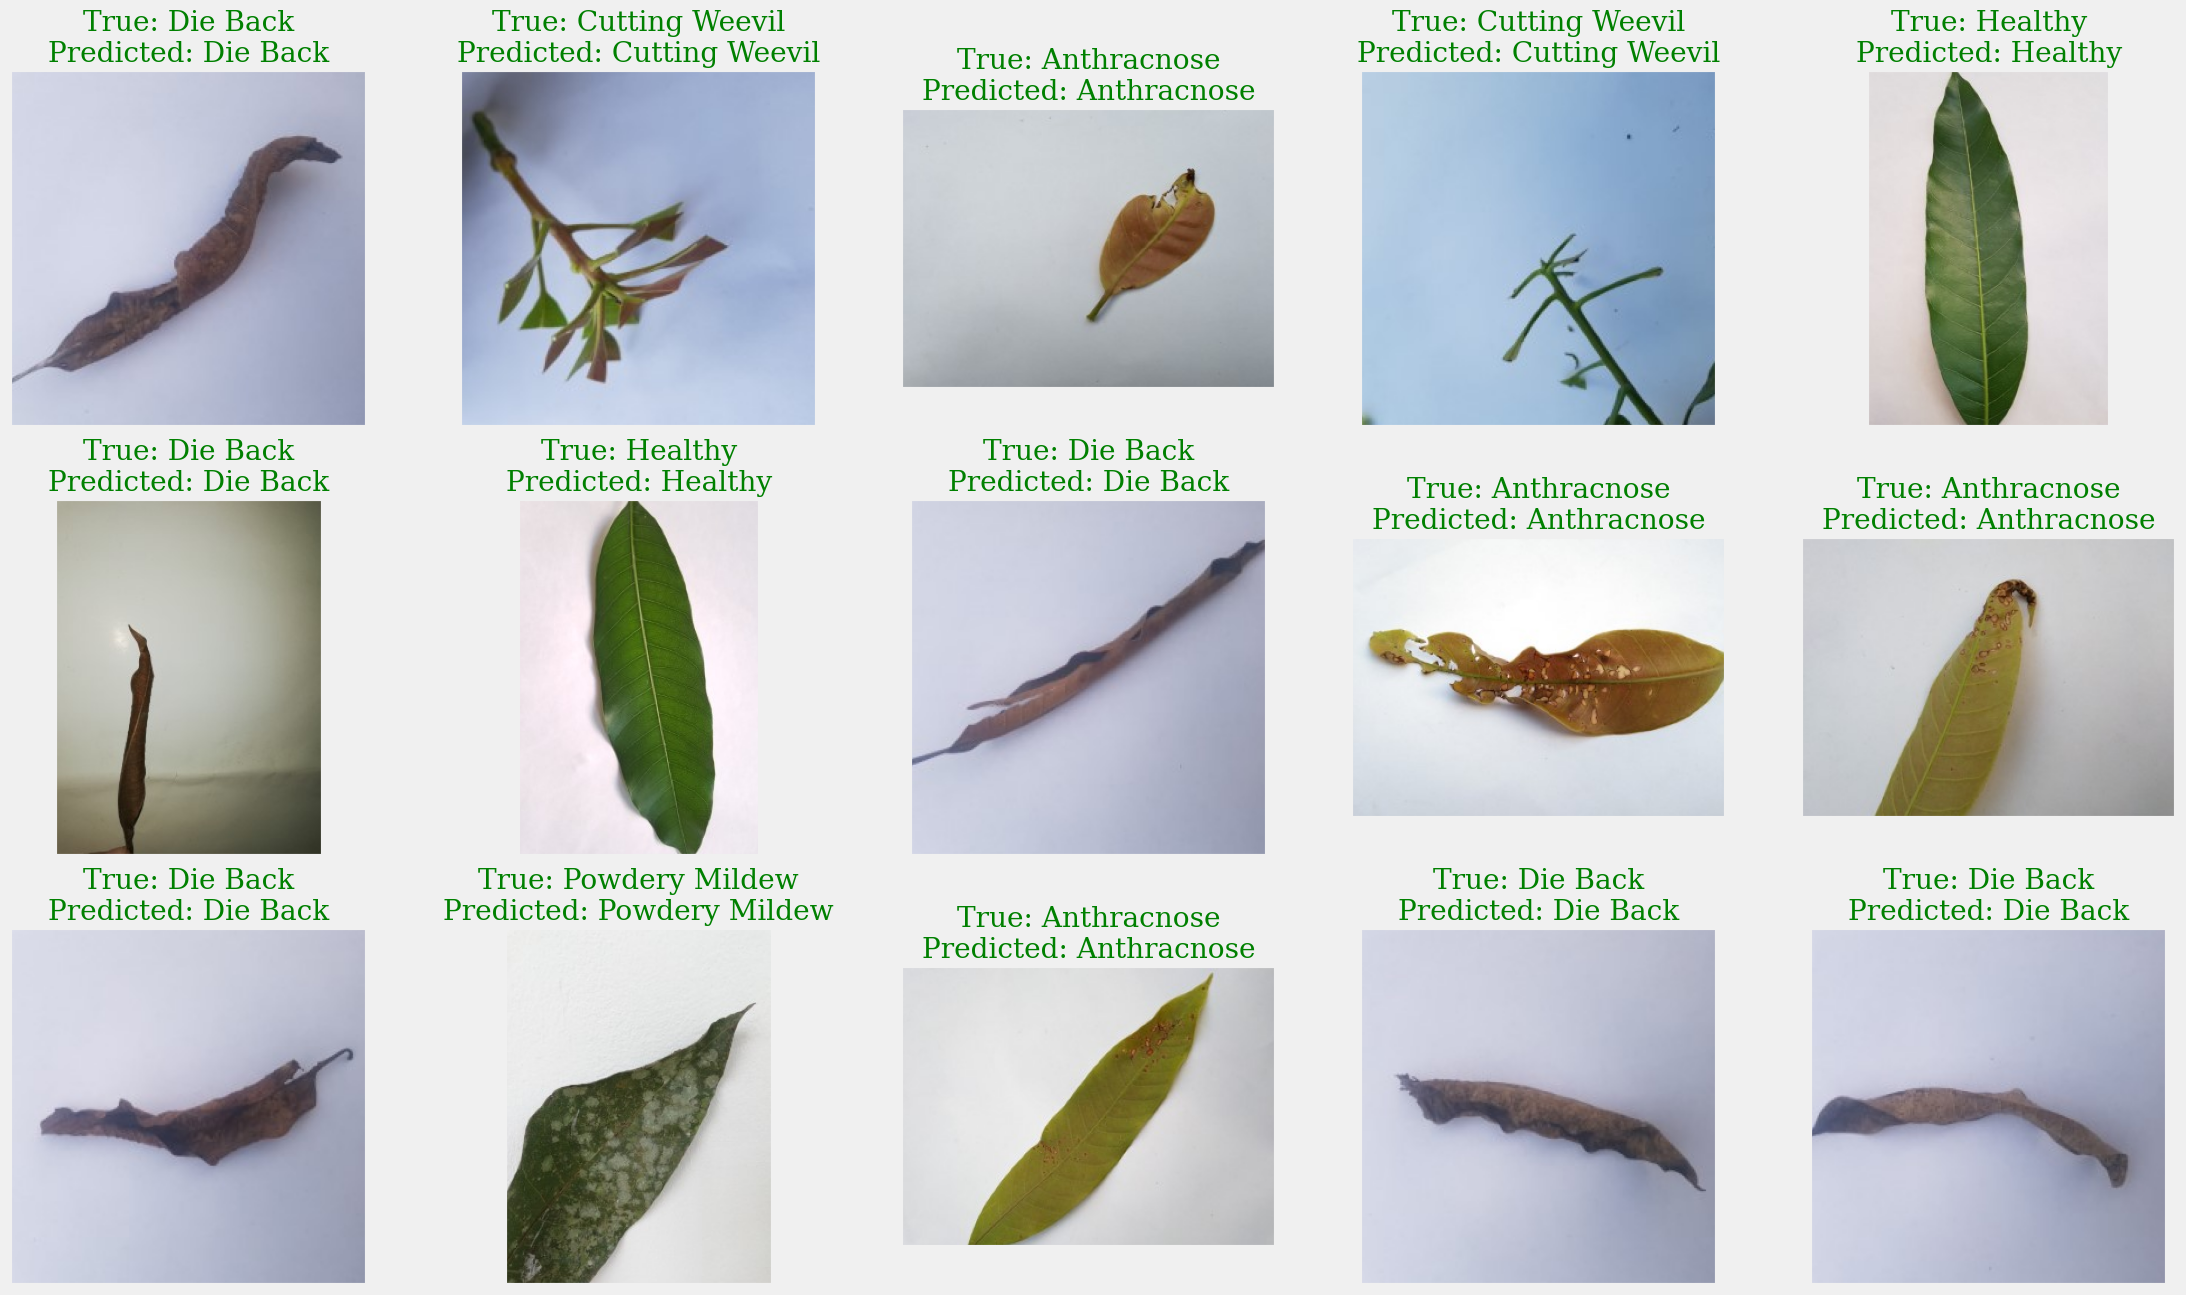

<Figure size 640x480 with 0 Axes>

In [ ]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [ ]:
import time

start_time = time.time()
model.predict(test_images)  # or any other input, just for demonstration
end_time = time.time()

print(f"Inference time: {end_time - start_time:.2f} seconds")

8/8 [==============================] - 1s 149ms/step
Inference time: 1.47 seconds


Class Anthracnose:
Precision: [0.2173913 1.        1.       ]
Recall: [1. 1. 0.]
Average Precision: 1.00

Class Cutting Weevil:
Precision: [0.13043478 1.         1.        ]
Recall: [1. 1. 0.]
Average Precision: 1.00

Class Die Back:
Precision: [0.2173913 1.        1.       ]
Recall: [1. 1. 0.]
Average Precision: 1.00

Class Healthy:
Precision: [0.2173913 1.        1.       ]
Recall: [1. 1. 0.]
Average Precision: 1.00

Class Powdery Mildew:
Precision: [0.2173913 1.        1.       ]
Recall: [1. 1. 0.]
Average Precision: 1.00



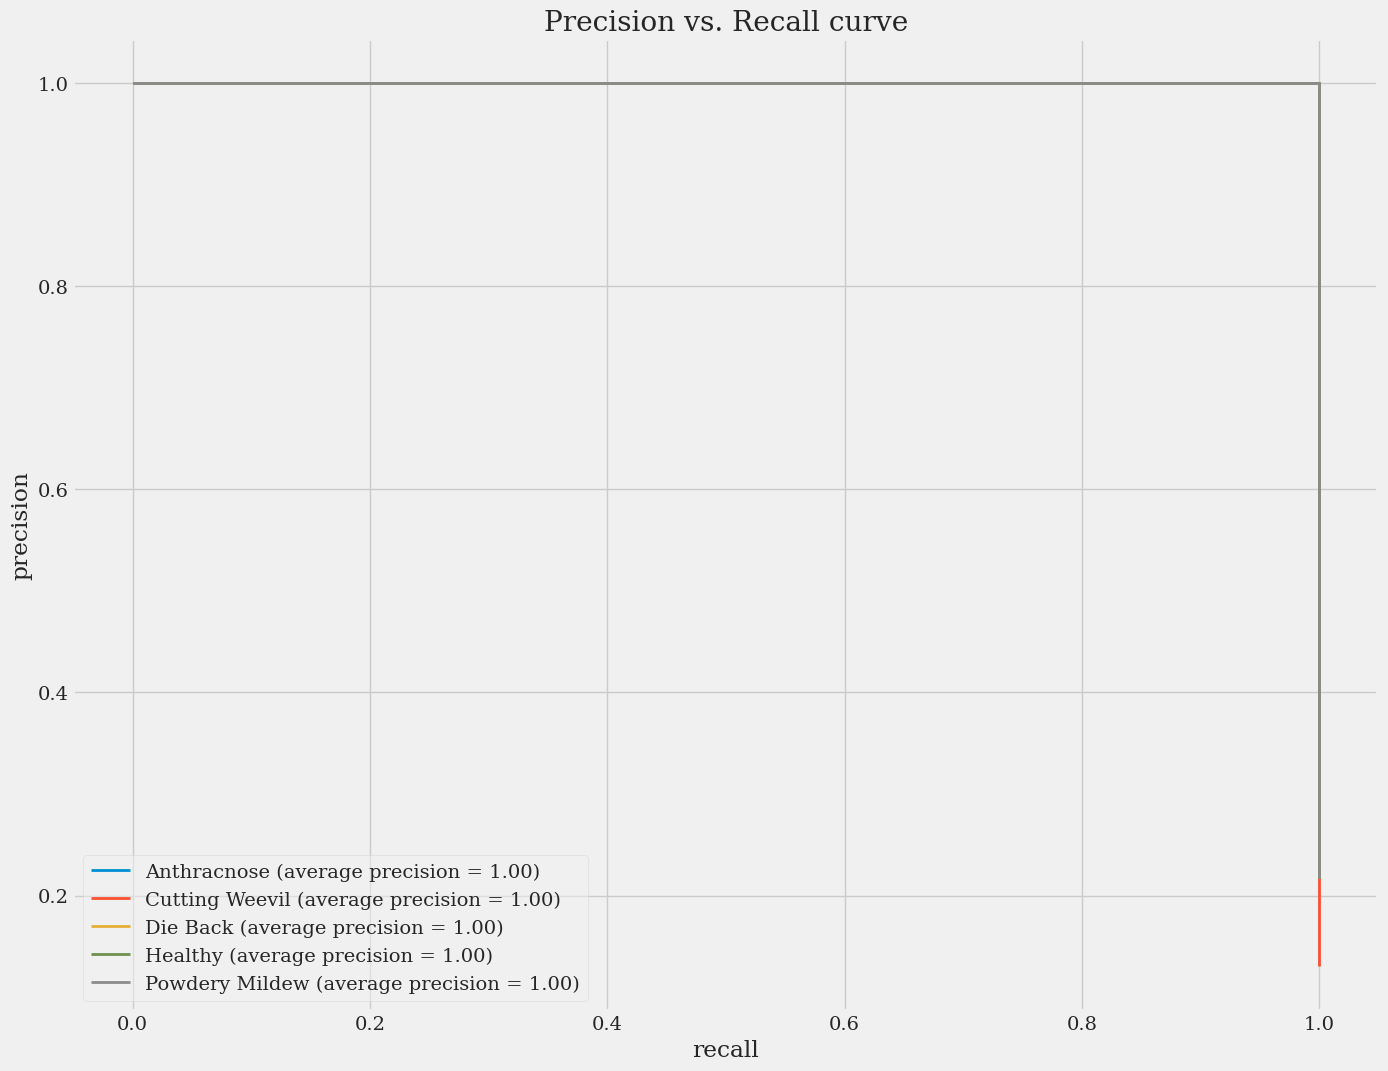

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

# Convert labels to one-hot encoding
lb = LabelBinarizer()
y_true_onehot = lb.fit_transform(test_df.Label)

# Convert predictions to one-hot encoding
y_pred_onehot = lb.transform(pred)

# For storing average precision for each class
average_precision = {}

# Get class names
class_names = lb.classes_

# Plot PR curve for each class
n_classes = y_true_onehot.shape[1]
plt.figure(figsize=(15, 12))

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_onehot[:, i], y_pred_onehot[:, i])
    average_precision[i] = average_precision_score(y_true_onehot[:, i], y_pred_onehot[:, i])

    # Printing the precision and recall values for each class using the actual class names
    print(f"Class {class_names[i]}:")
    print("Precision:", precision)
    print("Recall:", recall)
    print(f"Average Precision: {average_precision[i]:.2f}\n")

    plt.plot(recall, precision, lw=2, label=f'{class_names[i]} (average precision = {average_precision[i]:0.2f})')

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("Precision vs. Recall curve")
plt.grid(True)
plt.show()


In [ ]:
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
Anthracnose,1.0,1.0,1.0,50.0
Cutting Weevil,1.0,1.0,1.0,30.0
Die Back,1.0,1.0,1.0,50.0
Healthy,1.0,1.0,1.0,50.0
Powdery Mildew,1.0,1.0,1.0,50.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,230.0
weighted avg,1.0,1.0,1.0,230.0


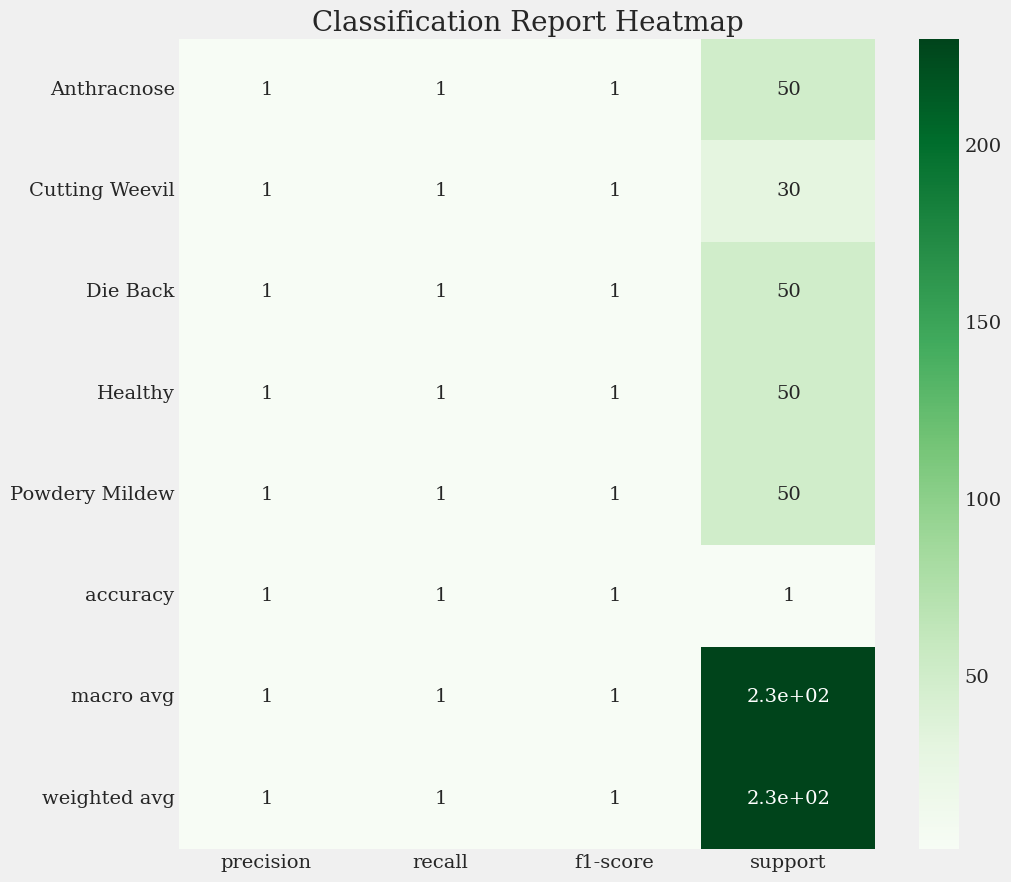

In [ ]:
# Remove the 'accuracy' row
#df = df.drop(['accuracy'])

# Remove the 'support' column
#df = df.drop(['support'], axis=1)

plt.figure(figsize=(10, 10))
sns.heatmap(df, annot=True, cmap='Greens')
plt.title('Classification Report Heatmap', fontsize=20)
plt.show()


In [ ]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(20, 14), text_size=10, norm=False, savefig=False):
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
    """
  # Create the confustion matrix

    # Use the fivethirtyeight style
    plt.style.use('fivethirtyeight')
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")


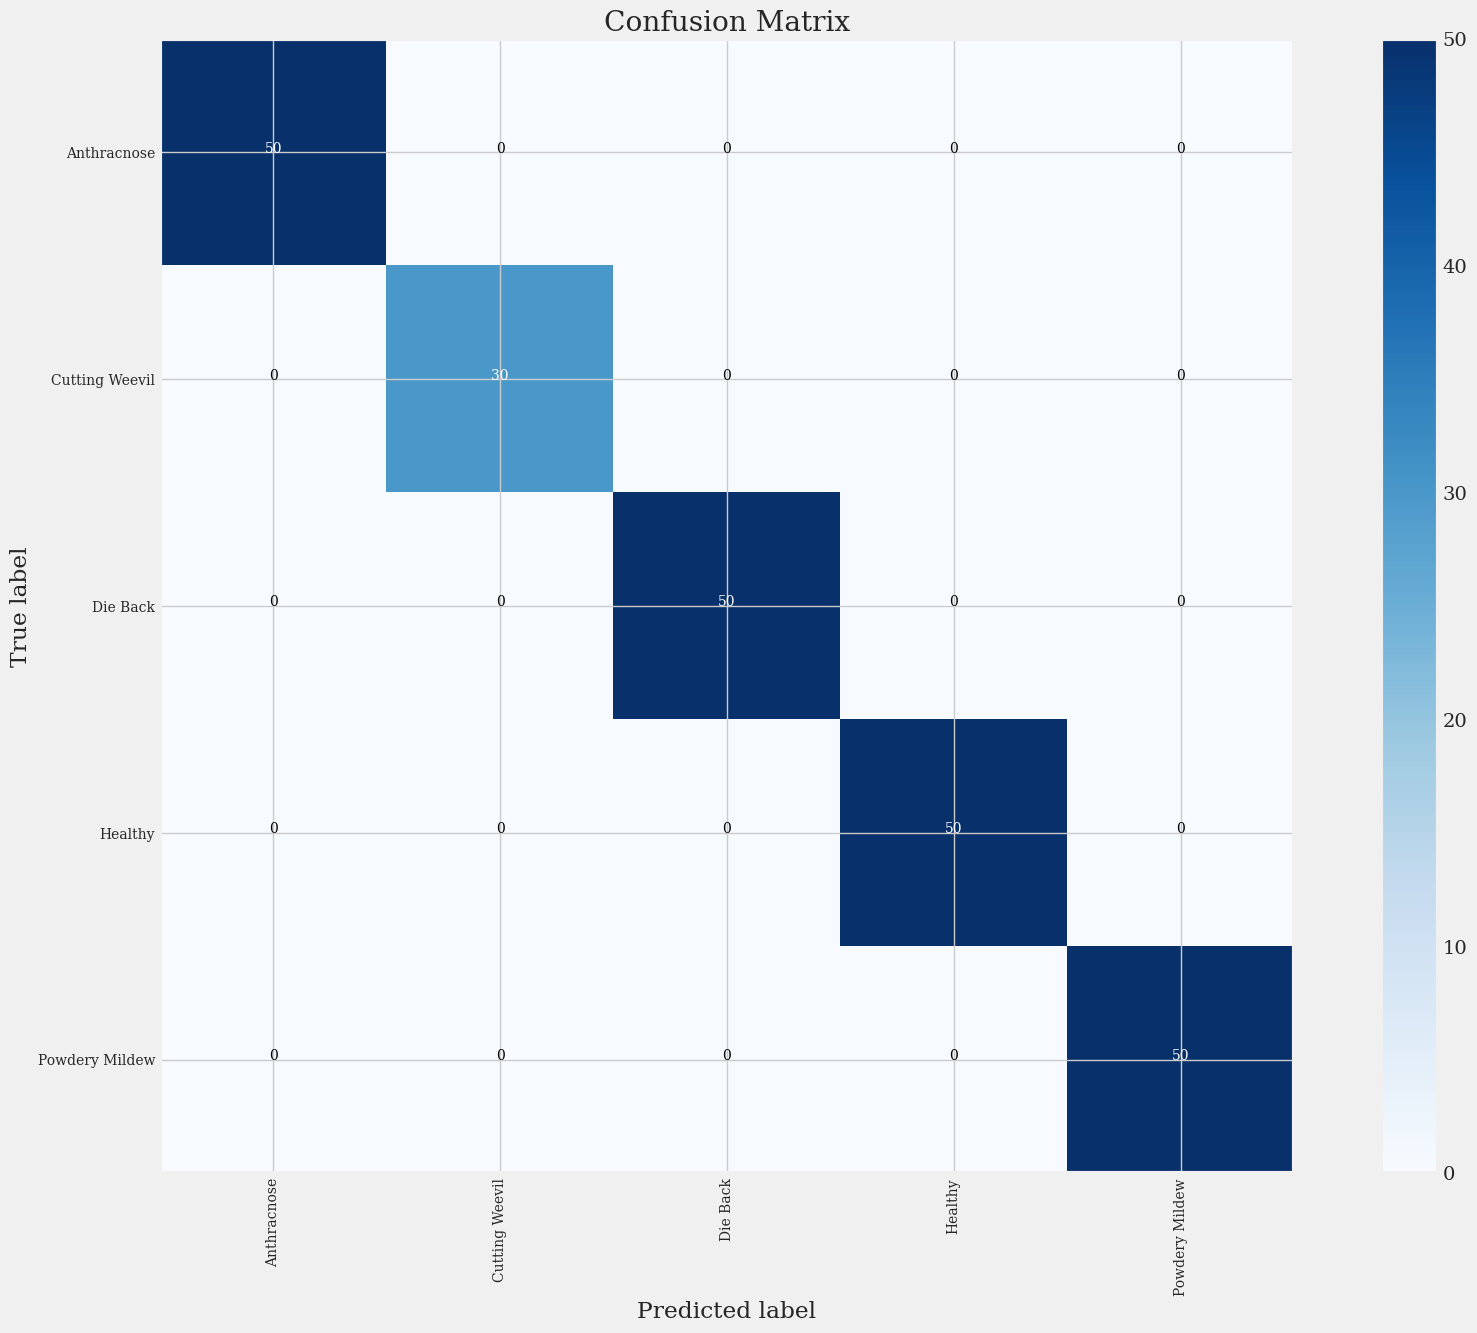

In [ ]:
make_confusion_matrix(y_test, pred, list(labels.values()))

In [ ]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))

    return cam_path

preprocess_input = tf.keras.applications.efficientnet.preprocess_input
decode_predictions = tf.keras.applications.efficientnet.decode_predictions

last_conv_layer_name = "conv5_block3_out"

img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

<ipython-input-130-6b83e14014a5>:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


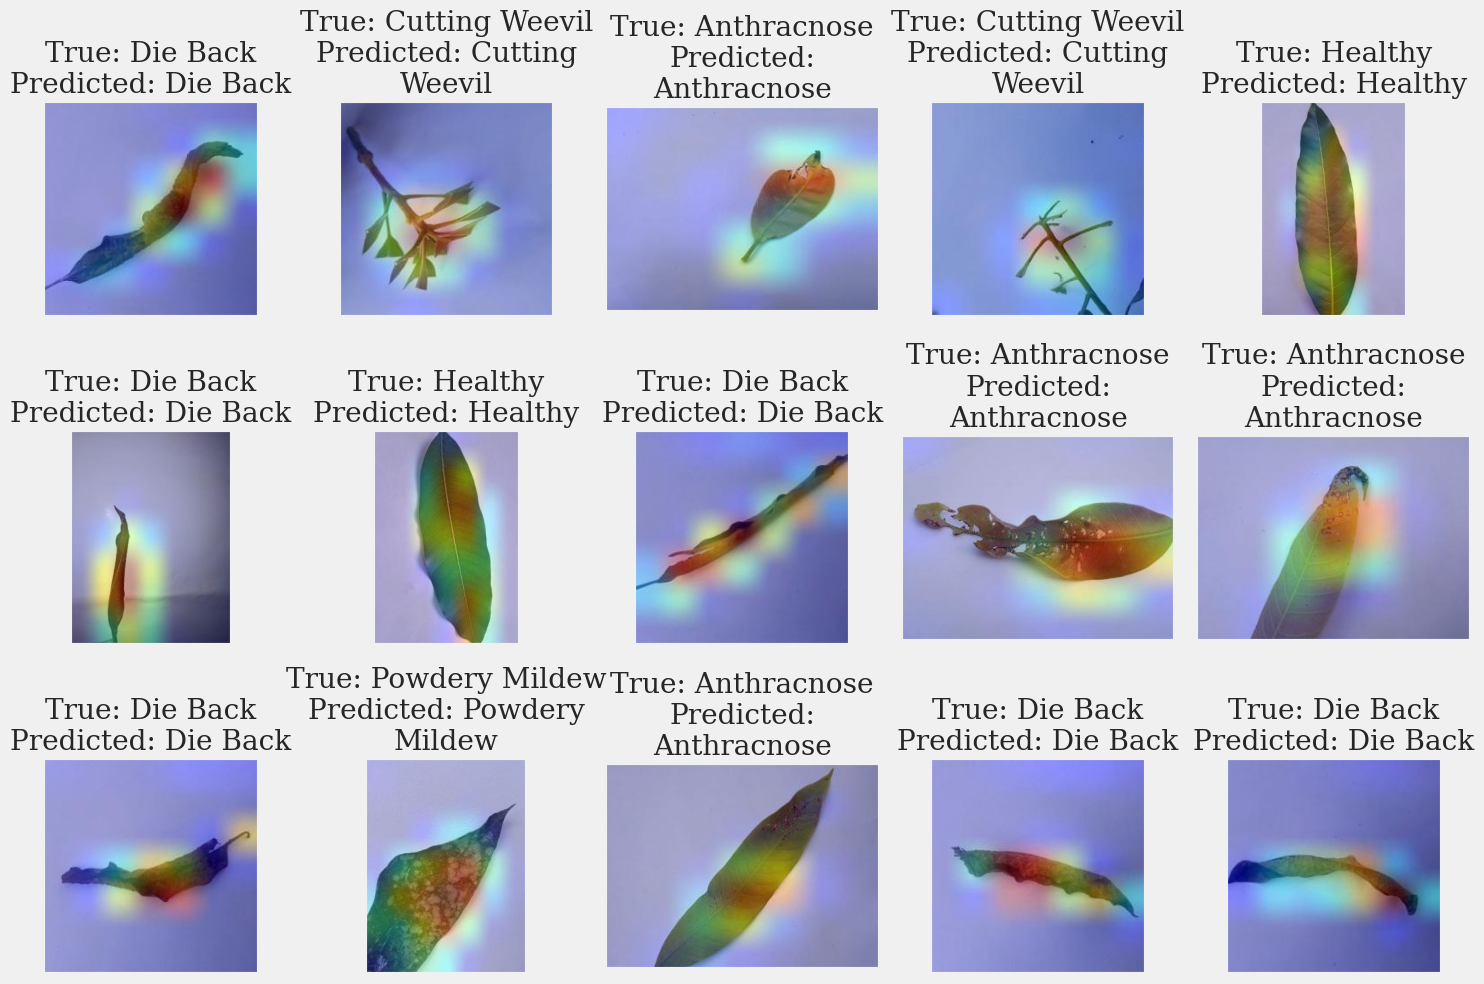

In [ ]:
import textwrap

# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))

    # Wrap the title text
    title_text = f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}"
    wrapped_title = '\n'.join(textwrap.wrap(title_text, 20))  # Adjust the number as needed
    ax.set_title(wrapped_title)

plt.tight_layout()
plt.show()
